# COGS 118A: Supervised Machine Learning Algorithms
## SVM with Scikit-Learn
In this notebook I found the best hyperparameters for an SVM using an RBF kernel operating on the Iris data.

The fitting and tuning was done on a k-fold cross validation on the training data, where using the k-fold reserves the seperate test set for evaluating the generalization error.

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns

### Load the modified Iris dataset

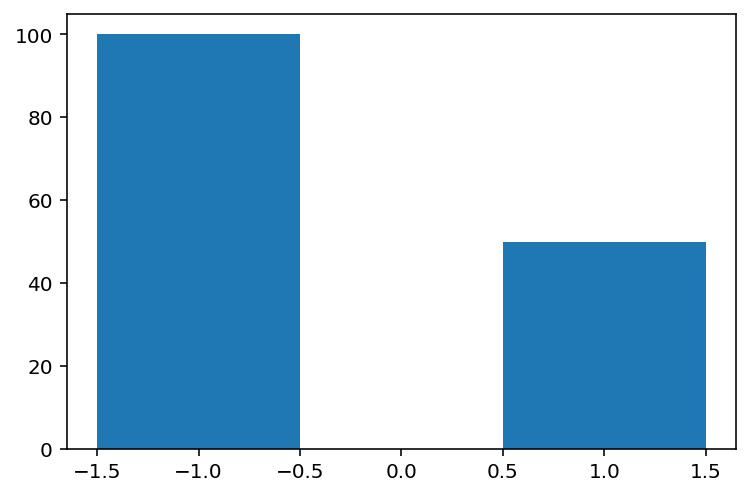

In [2]:
# Iris dataset.
iris = datasets.load_iris()     # Load Iris dataset.

X = iris.data                   # The shape of X is (150, 4), which means
                                # there are 150 data points, each data point
                                # has 4 features.

# Here for convenience, we divide the 3 kinds of flowers into 2 groups: 
#     Y = 0 (or False):  Setosa (original value 0) / Versicolor (original value 1)
#     Y = 1 (or True):   Virginica (original value 2)

# Thus we use (iris.target > 1.5) to divide the targets into 2 groups. 
# This line of code will assign:
#    Y[i] = True  (which is equivalent to 1) if iris.target[k]  > 1.5 (Virginica)
#    Y[i] = False (which is equivalent to 0) if iris.target[k] <= 1.5 (Setosa / Versicolor)

Y = (iris.target > 1.5).astype(np.float) # The shape of Y is (150, 1), which means 
                                # there are 150 data points, each data point
                                # has 1 target value. 
Y[Y==0] = -1

plt.hist(Y,bins=[-1.5,-0.5,0.5,1.5]); # let's see the class distribution, looks like it's mostly Class -1!

# get 100 in training set, 50 in test set. 
# Also let's stratify so that we force the training set to have the right class balance!
# this time we will use all the variables, not jsut 3 & 1
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=50, 
                                                     stratify=Y, shuffle=True ,random_state=1)

### SVM with RBF Using Scikit-Learn

In [3]:
# Draw the heatmap of training errors.
def draw_heatmap(training_errors):
    # training_errors: A NumPy array with the shape (len(C_list), len(gamma_list))
    # gamma_list: List of gamma(s).
    # C_list: List of C(s).
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(training_errors, annot=True, fmt='.3f', 
                     xticklabels=gamma_list, yticklabels=C_list)
    ax.collections[0].colorbar.set_label("error")
    ax.set(xlabel = '$\gamma$', ylabel='$C$')
    plt.title('Training error w.r.t $C$ and $\gamma$')
    plt.show()

In [9]:
C_list = [1, 10, 100, 1000, 10000]
gamma_list = [1e-6, 1e-5, 1e-4, 1e-3,1e-2]

# An example of using draw_heatmap().
#    errors = np.random.random((len(C_list), len(gamma_list)))
#    draw_heatmap(errors, gamma_list, C_list)

opt_e_training = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C          = None  # Optimal C.
opt_gamma      = None  # Optimal C.

# Training errors
training_errors = np.zeros((len(C_list), len(gamma_list)))

for i, C in enumerate(C_list):
    for j, gamma in enumerate(gamma_list):
        # Create a SVM classifier with RBF kernel.
        classifier = svm.SVC(kernel='rbf', C=C, gamma=gamma)
        
        # get the accuracy score from 5-fold cross-validation of the training data; see sklearn docs
        e_training = cross_val_score( classifier, X_train, Y_train, cv=5)
        # the above returns the accuracy on each fold, take the mean and inverse for misclassification error rate
        e_training = 1 - np.mean( e_training ) 
        
        training_errors[i,j] = e_training
        
        if e_training < opt_e_training:
            opt_e_training = e_training
            opt_classifier = classifier
            opt_C          = C
            opt_gamma      = gamma

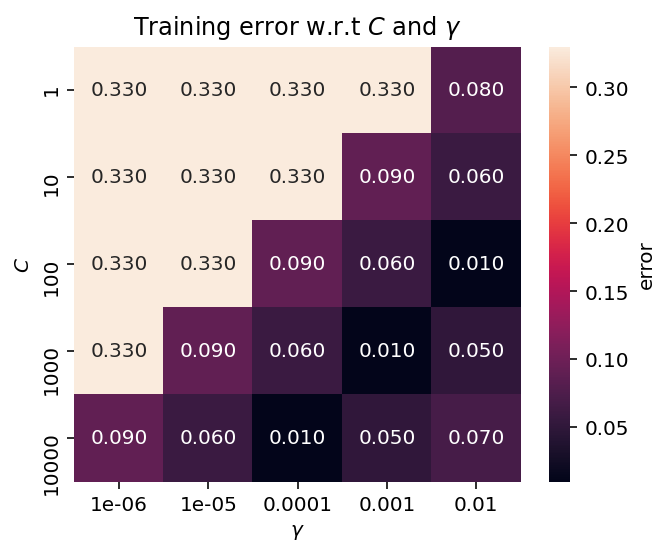

Test set error for optimum classifier(C=100,gamma=0.01): 0.020


In [10]:
draw_heatmap(training_errors)#, gamma_list, C_list)
opt_classifier.fit(X_train,Y_train)
opt_test_score = 1. - opt_classifier.score(X_test,Y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},gamma={opt_gamma}): {opt_test_score:.3f}') 

## But wait, there's an easier way!
You can do all the manual work of looping we did above using just 1 command in sklearn.  

Below please write the correct function call to duplicate the above 5-fold cross validation of `C_list` and `gamma_list` parameter sets using the function [GridSearchCV() and its documentation found here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) 

In [14]:
from sklearn.model_selection import GridSearchCV
classifier = svm.SVC(kernel='rbf')
search_results =  GridSearchCV(classifier, param_grid=dict(gamma=gamma_list, C=C_list))

search_results.fit(X_train,Y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10, 100, 1000, 10000],
                         'gamma': [1e-06, 1e-05, 0.0001, 0.001, 0.01]})

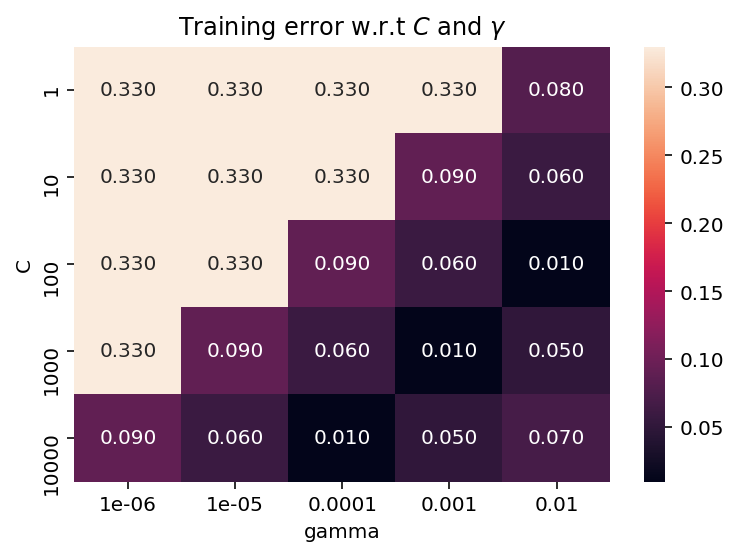

In [15]:
# here's how we can extract all the same information from the search_results data structure

# first get the parameters used in the order they were used
results = pd.DataFrame( search_results.cv_results_['params'] )

# next grab the score resulting from those parameters, add it to the data
# score is accuracy; to display it as misclassification error we use 1 - x
results['score'] = 1 - search_results.cv_results_['mean_test_score']

# turn a long table into a 2-D table with C being the 1st axis (y-axis) and gamma as the 2nd (x-axis)
results = results.pivot('C','gamma','score')

# and plot it
# using the dataframe means we don't need the wrapper fct around sns.heatmap we used before
sns.heatmap(results,annot=True, fmt='.3f') 
plt.title('Training error w.r.t $C$ and $\gamma$')
plt.show()

In [16]:
# extract the best estimator and its params
opt_classifier = search_results.best_estimator_
opt_C = search_results.best_params_['C']
opt_gamma = search_results.best_params_['gamma']

# just a copy/paste of test set evaluation from before
opt_classifier.fit(X_train,Y_train)
opt_test_score = 1 - opt_classifier.score(X_test,Y_test) # again turn accuracy into misclassification error
print(f'Test set error for optimum classifier(C={opt_C},gamma={opt_gamma}): {opt_test_score:.3f}') 


Test set error for optimum classifier(C=100,gamma=0.01): 0.020
